# FOLLOWING NOTEBOOK IS USED TO PERFORM LAND SUITABILITY ASSESSMENT USING PYTHON

### 1. This cell imports all the necessary Python libraries for spatial data processing, geospatial analysis, raster operations, array computations, and plotting.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
from rasterio import windows
from pyproj import Transformer
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm
import xml.etree.ElementTree as ET


### 2. Load the Digital Elevation Model (DEM) from a GeoTIFF file and display its metadata

In [2]:
dem_path = "AP_13298_FBD_F0450_RT1.dem.tif"  

with rasterio.open(dem_path) as src:
    print("\nDetailed Tags:")
    print(src.tags())

    transform = src.transform
    pixel_width = transform.a
    pixel_height = -transform.e  
    print(f"\nCell Size:\n  Width: {pixel_width} meters\n  Height: {pixel_height} meters")

    elevation = src.read(1)
    nodata = src.nodata

valid_elevation = elevation[elevation != nodata]

print("\nElevation Statistics:")
print(f"  Min:    {np.min(valid_elevation):.2f} meters")
print(f"  Max:    {np.max(valid_elevation):.2f} meters")
print(f"  Mean:   {np.mean(valid_elevation):.2f} meters")
print(f"  Median: {np.median(valid_elevation):.2f} meters")
print(f"  StdDev: {np.std(valid_elevation):.2f} meters")


Detailed Tags:
{'TIFFTAG_SOFTWARE': 'Created with GAMMA Software www.gamma-rs.ch', 'TIFFTAG_DATETIME': '2015:08:17 08:38:58', 'AREA_OR_POINT': 'Point'}

Cell Size:
  Width: 12.5 meters
  Height: 12.5 meters

Elevation Statistics:
  Min:    163.00 meters
  Max:    997.00 meters
  Mean:   517.72 meters
  Median: 551.00 meters
  StdDev: 123.29 meters


### 3. Displaying the detailed DEM metadata from xml file

In [3]:
tree = ET.parse("AP_13298_FBD_F0450_RT1.iso.xml")
root = tree.getroot()

namespaces = {
    'gmd': 'http://www.isotc211.org/2005/gmd',
    'gco': 'http://www.isotc211.org/2005/gco',
    'gmi': 'http://www.isotc211.org/2005/gmi',
    'gmx': 'http://www.isotc211.org/2005/gmx',
    'eos': 'http://earthdata.nasa.gov/schema/eos',
    'gml': 'http://www.opengis.net/gml/3.2'
}

def get_text(element):
    return element.text.strip() if element is not None and element.text is not None else "N/A"

dem_metadata = {}
image_bounding_box = {}
data_acquisition = {}

for dataset in root.findall('.//gmd:DS_DataSet/gmd:has/gmi:MI_Metadata', namespaces):
    
    title_elem = dataset.find('.//gmd:MD_DataIdentification/gmd:citation/gmd:CI_Citation/gmd:title/gmx:FileName', namespaces)
    if title_elem is not None:
        title = get_text(title_elem)
        
        if title == "AP_13298_FBD_F0450_RT1.dem.tif":
           
            dem_metadata['File Name'] = title
                     
            alt_title = dataset.find('.//gmd:MD_DataIdentification/gmd:citation/gmd:CI_Citation/gmd:alternateTitle/gco:CharacterString', namespaces)
            dem_metadata['Alternate Title'] = get_text(alt_title)
            
            creation_date = dataset.find('.//gmd:MD_DataIdentification/gmd:citation/gmd:CI_Citation/gmd:date/gmd:CI_Date/gmd:date/gco:DateTime', namespaces)
            dem_metadata['Creation Date'] = get_text(creation_date)

            org_name = dataset.find('.//gmd:MD_DataIdentification/gmd:citation/gmd:CI_Citation/gmd:citedResponsibleParty/gmd:CI_ResponsibleParty/gmd:organisationName/gco:CharacterString', namespaces)
            dem_metadata['Organization'] = get_text(org_name)

            rows, cols, resolution = "N/A", "N/A", "N/A"
            grid_repr = dataset.find('.//gmd:MD_GridSpatialRepresentation', namespaces)
            if grid_repr is not None:
                for dimension in grid_repr.findall('.//gmd:axisDimensionProperties/gmd:MD_Dimension', namespaces):
                    dim_name = dimension.find('.//gmd:dimensionName/gmd:MD_DimensionNameTypeCode', namespaces)
                    if dim_name is not None and dim_name.get('codeListValue') == "row":
                        rows_elem = dimension.find('.//gmd:dimensionSize/gco:Integer', namespaces)
                        rows = get_text(rows_elem)
                        res_elem = dimension.find('.//gmd:resolution/gco:Distance', namespaces)
                        resolution = get_text(res_elem)
                    elif dim_name is not None and dim_name.get('codeListValue') == "column":
                        cols_elem = dimension.find('.//gmd:dimensionSize/gco:Integer', namespaces)
                        cols = get_text(cols_elem)
            dem_metadata['Dimensions'] = f"{rows} rows x {cols} columns"
            dem_metadata['Resolution'] = f"{resolution} meters"

            map_projection = dataset.find('.//gmd:MD_GridSpatialRepresentation/eos:otherProperty/gco:Record/eos:additionalAttributes/eos:EOS_AdditionalAttributes/eos:additionalAttribute/eos:EOS_AdditionalAttribute/eos:value/gco:CharacterString', namespaces)
            dem_metadata['Map Projection'] = get_text(map_projection)

            west_lon = dataset.find('.//gmd:MD_DataIdentification/gmd:extent/gmd:EX_Extent/gmd:geographicElement/gmd:EX_GeographicBoundingBox/gmd:westBoundLongitude/gco:Decimal', namespaces)
            east_lon = dataset.find('.//gmd:MD_DataIdentification/gmd:extent/gmd:EX_Extent/gmd:geographicElement/gmd:EX_GeographicBoundingBox/gmd:eastBoundLongitude/gco:Decimal', namespaces)
            south_lat = dataset.find('.//gmd:MD_DataIdentification/gmd:extent/gmd:EX_Extent/gmd:geographicElement/gmd:EX_GeographicBoundingBox/gmd:southBoundLatitude/gco:Decimal', namespaces)
            north_lat = dataset.find('.//gmd:MD_DataIdentification/gmd:extent/gmd:EX_Extent/gmd:geographicElement/gmd:EX_GeographicBoundingBox/gmd:northBoundLatitude/gco:Decimal', namespaces)
            dem_metadata['Geographic Extent'] = f"West: {get_text(west_lon)}, East: {get_text(east_lon)}, South: {get_text(south_lat)}, North: {get_text(north_lat)}"

            max_val = dataset.find('.//gmd:MD_CoverageDescription/gmd:dimension/gmi:MI_Band/gmd:maxValue/gco:Real', namespaces)
            min_val = dataset.find('.//gmd:MD_CoverageDescription/gmd:dimension/gmi:MI_Band/gmd:minValue/gco:Real', namespaces)
            mean_val = dataset.find('.//gmd:MD_CoverageDescription/gmd:dimension/gmi:MI_Band/gmd:meanValue/gco:Real', namespaces)
            std_dev = dataset.find('.//gmd:MD_CoverageDescription/gmd:dimension/gmi:MI_Band/gmd:standardDeviation/gco:Real', namespaces)
            dem_metadata['Elevation Stats'] = f"Max: {get_text(max_val)} m, Min: {get_text(min_val)} m, Mean: {get_text(mean_val)} m, Std Dev: {get_text(std_dev)} m"
        
        elif title == "AP_13298_FBD_F0450_RT1_HH.tif,AP_13298_FBD_F0450_RT1_HV.tif":

            bbox = dataset.find('.//gmd:MD_DataIdentification/gmd:extent/gmd:EX_Extent/gmd:geographicElement/gmd:EX_GeographicBoundingBox[@id="imageBoundingBox"]', namespaces)
            if bbox is not None:
                west_lon = bbox.find('.//gmd:westBoundLongitude/gco:Decimal', namespaces)
                east_lon = bbox.find('.//gmd:eastBoundLongitude/gco:Decimal', namespaces)
                south_lat = bbox.find('.//gmd:southBoundLatitude/gco:Decimal', namespaces)
                north_lat = bbox.find('.//gmd:northBoundLatitude/gco:Decimal', namespaces)
                image_bounding_box['Image Bounding Box'] = f"West: {get_text(west_lon)}, East: {get_text(east_lon)}, South: {get_text(south_lat)}, North: {get_text(north_lat)}"

            temporal_extent = dataset.find('.//gmd:MD_DataIdentification/gmd:extent/gmd:EX_Extent/gmd:temporalElement/gmd:EX_TemporalExtent[@id="imageTemporalExtent"]', namespaces)
            if temporal_extent is not None:
                begin_time = temporal_extent.find('.//gml:TimePeriod/gml:beginPosition', namespaces)
                end_time = temporal_extent.find('.//gml:TimePeriod/gml:endPosition', namespaces)
                data_acquisition['Data Acquisition'] = f"Begin: {get_text(begin_time)}, End: {get_text(end_time)}"

combined_metadata = {**dem_metadata, **image_bounding_box, **data_acquisition}

print("\033[1;4m=== DEM Metadata with Image Bounding Box and Data Acquisition ===\033[0m")
for key, value in combined_metadata.items():
    print(f"\033[1;4m{key}\033[0m: {value}")

=== DEM Metadata with Image Bounding Box and Data Acquisition ===
File Name: AP_13298_FBD_F0450_RT1.dem.tif
Alternate Title: DEM used for terrain correction: SRTMGL1 - Shuttle Radar Topography mission at 30 m resolution. Additional corrections by the Alaska Satellite Facility (June 2015, version 1.1).
Creation Date: 2015-08-17T08:39:18.000000Z
Organization: U.S. Geological Survey (USGS) - USGS Earth Resources Observation & Science (EROS) Center
Dimensions: 5564 rows x 6281 columns
Resolution: 12.5 meters
Map Projection: PROJCS["Universal_Transverse_Mercator",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199432955]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",87.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]
Geographic Extent: West: 84.90713, East: 85.68242, South: 22.9534

### 4. Plotting the Elevation raster, histogram & table.

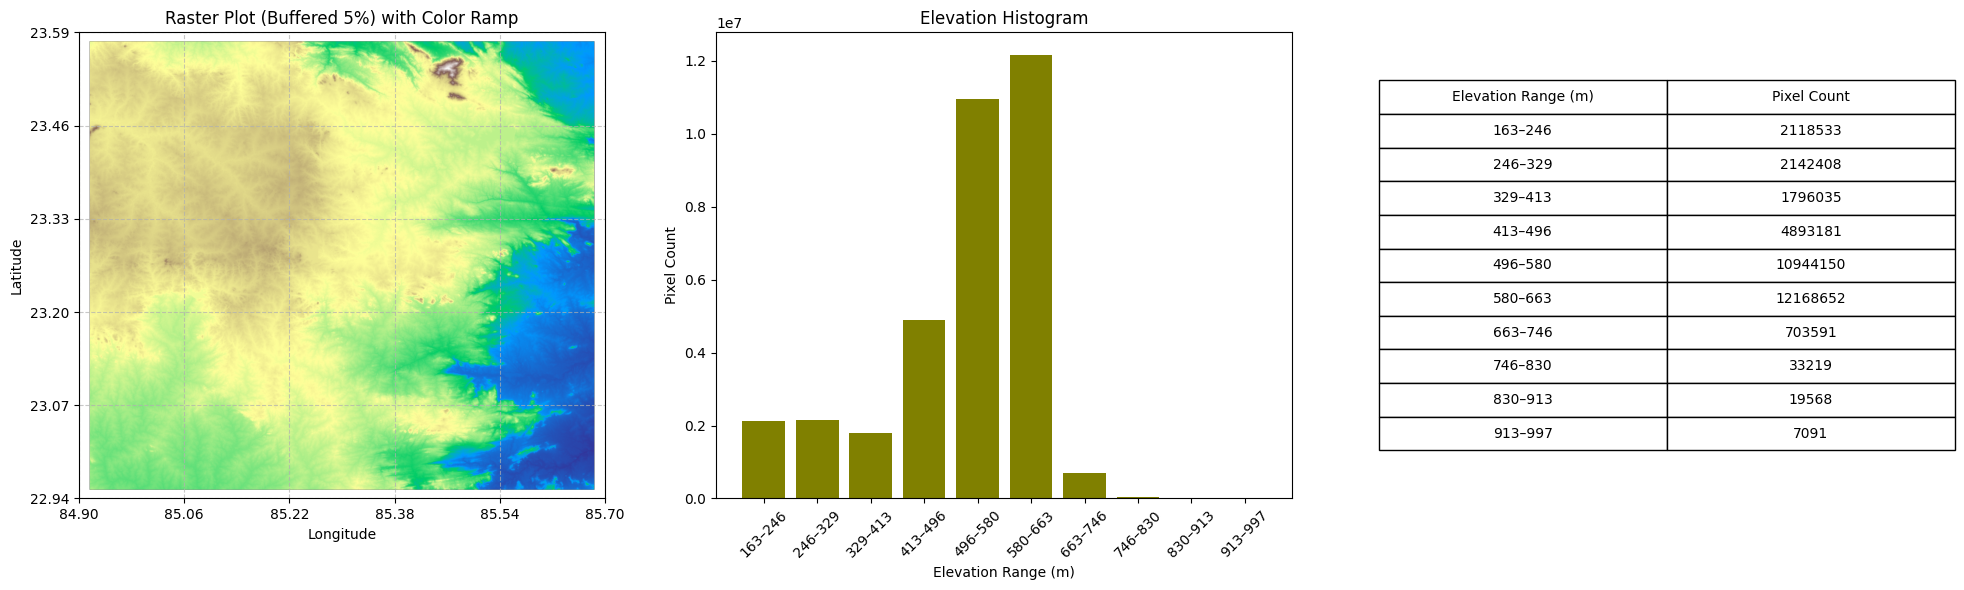

In [4]:
dem = rasterio.open("AP_13298_FBD_F0450_RT1.dem.tif")

crs = dem.crs
transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)  
dem_data = dem.read(1)
dem_data = dem_data[dem_data != dem.nodata]
bounds = dem.bounds
x_buffer = (bounds.right - bounds.left) * 0.02  
y_buffer = (bounds.top - bounds.bottom) * 0.02 
x_min, x_max = bounds.left - x_buffer, bounds.right + x_buffer
y_min, y_max = bounds.bottom - y_buffer, bounds.top + y_buffer
x_coords = [x_min, x_max]
y_coords = [y_min, y_max]
xx, yy = np.meshgrid(x_coords, y_coords)
lon, lat = transformer.transform(xx, yy)
hist_vals, bin_edges = np.histogram(dem_data, bins=10)
bin_labels = [f"{int(bin_edges[i])}–{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
hist_df = pd.DataFrame({
    "Elevation Range (m)": bin_labels,
    "Pixel Count": hist_vals
})
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

cmap = plt.cm.terrain  
show(dem, ax=axs[0], cmap=cmap)
axs[0].set_xlim(x_min, x_max)
axs[0].set_ylim(y_min, y_max)
axs[0].set_title("Raster Plot (Buffered 5%) with Color Ramp")

x_ticks = np.linspace(x_min, x_max, num=6)
y_ticks = np.linspace(y_min, y_max, num=6)
x_ticks_lon, _ = transformer.transform(x_ticks, np.full_like(x_ticks, y_min))
_, y_ticks_lat = transformer.transform(np.full_like(y_ticks, x_min), y_ticks)

axs[0].set_xticks(x_ticks)
axs[0].set_yticks(y_ticks)
axs[0].set_xticklabels([f"{lon:.2f}" for lon in x_ticks_lon])
axs[0].set_yticklabels([f"{lat:.2f}" for lat in y_ticks_lat])
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
axs[0].grid(True, linestyle="--", alpha=0.7)

axs[1].bar(bin_labels, hist_vals, color="olive")
axs[1].set_title("Elevation Histogram")
axs[1].set_xlabel("Elevation Range (m)")
axs[1].set_ylabel("Pixel Count")
axs[1].tick_params(axis="x", rotation=45)

axs[2].axis("off")  
table = axs[2].table(
    cellText=hist_df.values,
    colLabels=hist_df.columns,
    cellLoc="center",
    loc="center"
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  

plt.tight_layout()
plt.show()

### 5. Calculating slope from the elevation raster, plotting the slope, histogram & table

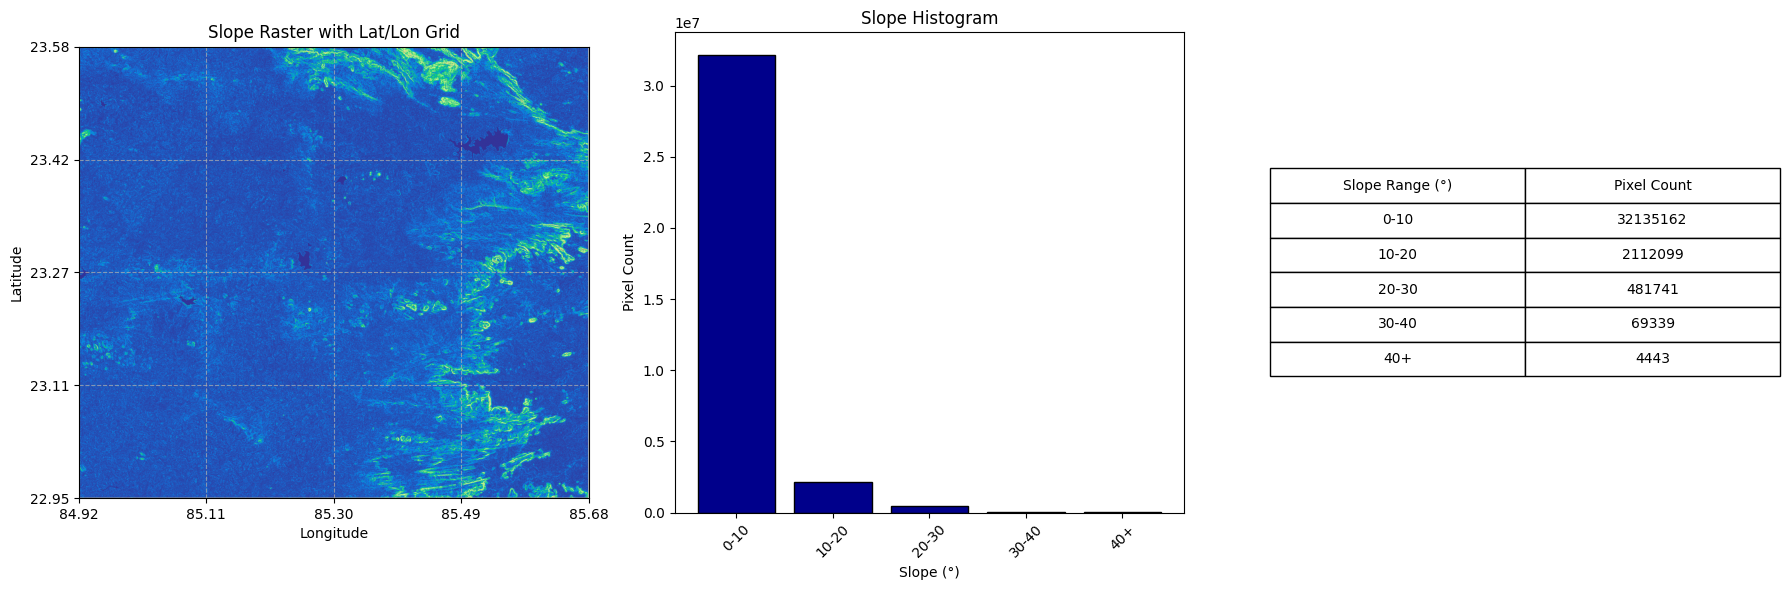

In [5]:
dem_path = "AP_13298_FBD_F0450_RT1.dem.tif"
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)  
    transform = src.transform
    nodata = src.nodata
    crs = src.crs  
    profile = src.profile  
    bounds = src.bounds  

pixel_size_x = transform[0]       
pixel_size_y = abs(transform[4]) 

valid_mask = (dem_data != nodata)
dem_data = np.where(valid_mask, dem_data, np.nan)

dz_dy, dz_dx = np.gradient(dem_data, pixel_size_y, pixel_size_x)

slope_rad = np.sqrt(dz_dx**2 + dz_dy**2)
slope_rad = np.arctan(slope_rad) 

slope_deg = np.degrees(slope_rad)

slope_path = "slope2.tif"
profile.update(
    dtype=rasterio.float32,  
    nodata=np.nan,           
    count=1                  
)
with rasterio.open(slope_path, 'w', **profile) as dst:
    dst.write(slope_deg.astype(rasterio.float32), 1)
 
slope_valid = slope_deg[~np.isnan(slope_deg)]
bins = [0, 10, 20, 30, 40, np.inf]  
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40+']  
bin_indices = np.digitize(slope_valid, bins, right=False) - 1  
bin_indices = np.clip(bin_indices, 0, len(bin_labels) - 1)  
 
pixel_counts = np.zeros(len(bin_labels), dtype=int)
for i in range(len(bin_labels)):
    pixel_counts[i] = np.sum(bin_indices == i)

hist_df = pd.DataFrame({
    "Slope Range (°)": bin_labels,
    "Pixel Count": pixel_counts
})

transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

im = axs[0].imshow(slope_deg, cmap=plt.cm.terrain,
                   extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
axs[0].set_title("Slope Raster with Lat/Lon Grid")
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")

proj_xticks = np.linspace(bounds.left, bounds.right, num=5)
proj_yticks = np.linspace(bounds.bottom, bounds.top, num=5)
x_ticks_lon, _ = transformer.transform(proj_xticks, np.full_like(proj_xticks, bounds.bottom))
_, y_ticks_lat = transformer.transform(np.full_like(proj_yticks, bounds.left), proj_yticks)
axs[0].set_xticks(proj_xticks)
axs[0].set_yticks(proj_yticks)
axs[0].set_xticklabels([f"{lon:.2f}" for lon in x_ticks_lon])
axs[0].set_yticklabels([f"{lat:.2f}" for lat in y_ticks_lat])
axs[0].grid(True, linestyle="--", alpha=0.7)

axs[1].bar(bin_labels, pixel_counts, color="darkblue", edgecolor="black")
axs[1].set_title("Slope Histogram")
axs[1].set_xlabel("Slope (°)")
axs[1].set_ylabel("Pixel Count")
axs[1].tick_params(axis="x", rotation=45)

axs[2].axis("off") 
table = axs[2].table(cellText=hist_df.values,
                     colLabels=hist_df.columns,
                     cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)  

plt.tight_layout()
plt.show()

## Preprocessing rainfall data

### 6. Plotting rainfall data overlayed on elevation raster

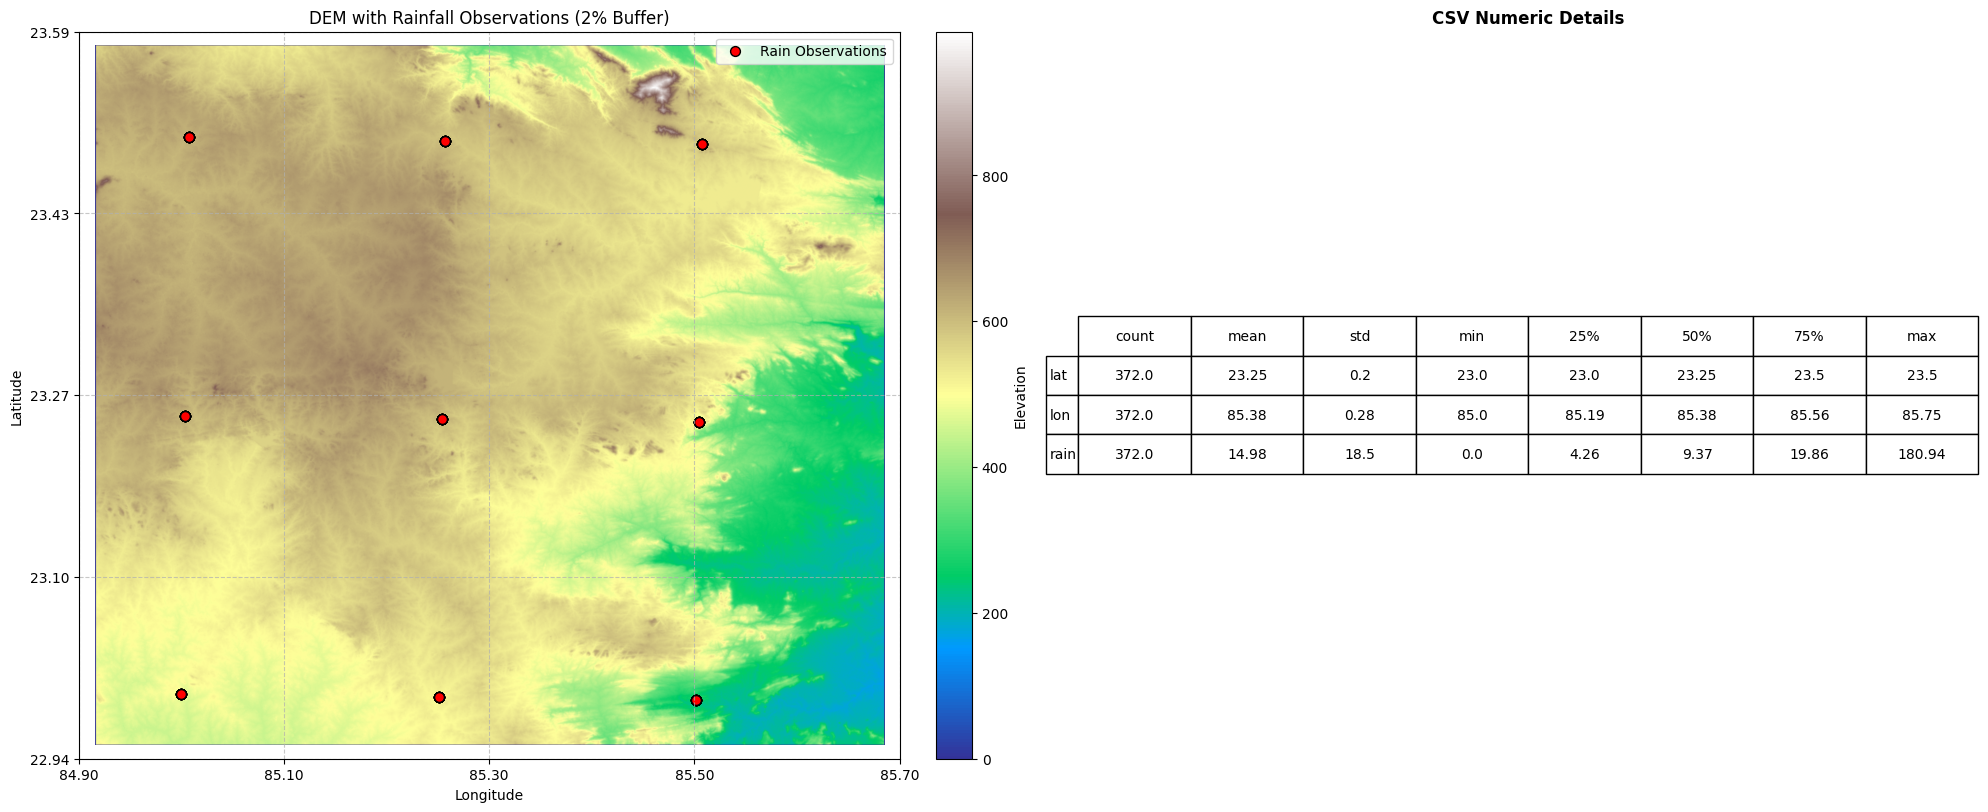

In [6]:
raster_path = "AP_13298_FBD_F0450_RT1.dem.tif"
with rasterio.open(raster_path) as src:
    dem_data = src.read(1)
    bounds = src.bounds
    crs = src.crs

orig_left, orig_right = bounds.left, bounds.right
orig_bottom, orig_top = bounds.bottom, bounds.top

x_buffer = (orig_right - orig_left) * 0.02
y_buffer = (orig_top - orig_bottom) * 0.02

x_min = orig_left - x_buffer
x_max = orig_right + x_buffer
y_min = orig_bottom - y_buffer
y_max = orig_top + y_buffer

csv_path = "imdlib_rain_2008-07-01_to_2008-07-31_polygon_rain.csv"
df = pd.read_csv(csv_path)

transformer_to_dem = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
xs, ys = transformer_to_dem.transform(df['lon'].values, df['lat'].values)
df['x'] = xs
df['y'] = ys

stats = df[['lat', 'lon', 'rain']].describe().T.round(2)

fig, (ax_map, ax_table) = plt.subplots(1, 2, figsize=(20, 8))

im = ax_map.imshow(dem_data, cmap=plt.cm.terrain,
                     extent=[orig_left, orig_right, orig_bottom, orig_top])
ax_map.set_title("DEM with Rainfall Observations (2% Buffer)")
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")

ax_map.set_xlim(x_min, x_max)
ax_map.set_ylim(y_min, y_max)

cbar = plt.colorbar(im, ax=ax_map, fraction=0.046, pad=0.04)
cbar.set_label("Elevation")

proj_xticks = np.linspace(x_min, x_max, num=5)
proj_yticks = np.linspace(y_min, y_max, num=5)

proj_to_latlon = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
x_ticks_lon, _ = proj_to_latlon.transform(proj_xticks, np.full_like(proj_xticks, y_min))
_, y_ticks_lat = proj_to_latlon.transform(np.full_like(proj_yticks, x_min), proj_yticks)
ax_map.set_xticks(proj_xticks)
ax_map.set_yticks(proj_yticks)
ax_map.set_xticklabels([f"{lon:.2f}" for lon in x_ticks_lon])
ax_map.set_yticklabels([f"{lat:.2f}" for lat in y_ticks_lat])
ax_map.grid(True, linestyle="--", alpha=0.7)

ax_map.scatter(df['x'], df['y'], c='red', edgecolor='black', marker='o', s=50, label="Rain Observations")
ax_map.legend()

ax_table.axis("off")
table = ax_table.table(cellText=stats.values,
                       rowLabels=stats.index,
                       colLabels=list(stats.columns),
                       loc='center',
                       cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax_table.set_title("Rainfall Details", fontweight="bold")

plt.tight_layout()
plt.show()

### 7. Performing the IDW interpolation on rainfall observations

Interpolated raster saved to 'IDW_Rainfall.tif'


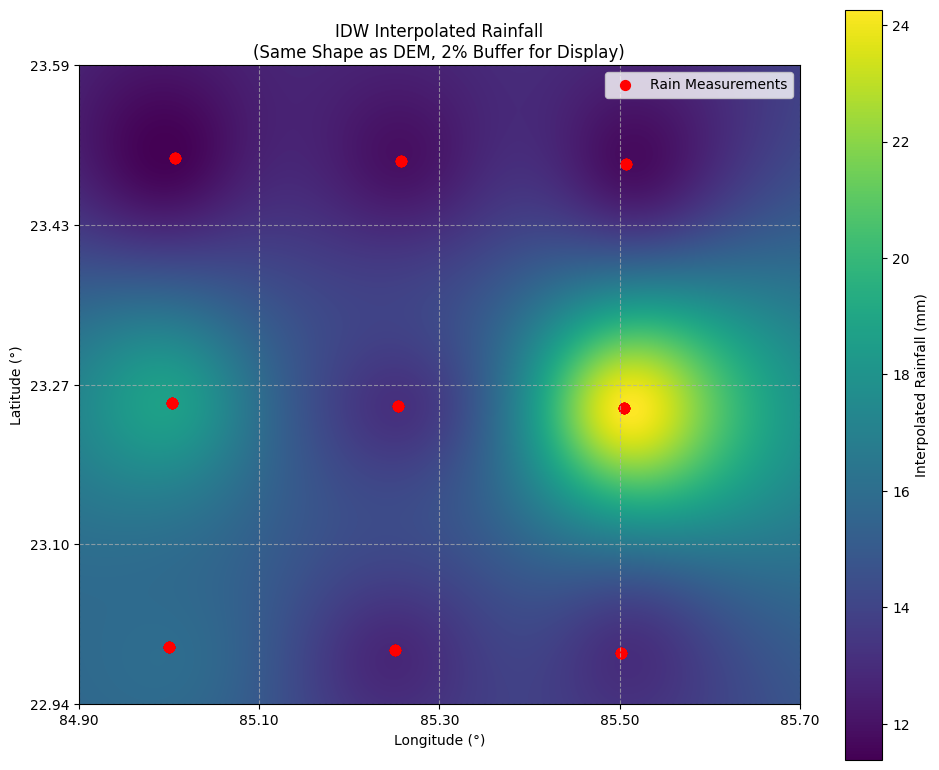

In [7]:
raster_path = "AP_13298_FBD_F0450_RT1.dem.tif"
with rasterio.open(raster_path) as src:
    dem_bounds = src.bounds
    dem_crs = src.crs
    dem_shape = src.shape  
    height, width = src.height, src.width

orig_left   = dem_bounds.left
orig_right  = dem_bounds.right
orig_bottom = dem_bounds.bottom
orig_top    = dem_bounds.top

x_buffer = (orig_right - orig_left) * 0.02
y_buffer = (orig_top - orig_bottom) * 0.02
buffered_left   = orig_left - x_buffer
buffered_right  = orig_right + x_buffer
buffered_bottom = orig_bottom - y_buffer
buffered_top    = orig_top + y_buffer

csv_path = "imdlib_rain_2008-07-01_to_2008-07-31_polygon_rain.csv"
df = pd.read_csv(csv_path)
transformer_to_dem = Transformer.from_crs("EPSG:4326", dem_crs, always_xy=True)
df['x'], df['y'] = transformer_to_dem.transform(df['lon'].values, df['lat'].values)

inside_mask = (
    (df['x'] >= orig_left) & (df['x'] <= orig_right) &
    (df['y'] >= orig_bottom) & (df['y'] <= orig_top)
)
df_inside = df[inside_mask]
if df_inside.empty:
    raise ValueError("No CSV points fall within the DEM extent!")

cell_size = 12.5  # in DEM units (e.g., meters)
grid_x = np.arange(orig_left, orig_right + cell_size, cell_size)
grid_y = np.arange(orig_bottom, orig_top + cell_size, cell_size)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

def idw_interpolation(x_points, y_points, values, xi, yi, power=2):
    interp = np.zeros(xi.shape, dtype=float)
    for i in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            pt_x = xi[i, j]
            pt_y = yi[i, j]
            distances = np.sqrt((x_points - pt_x)**2 + (y_points - pt_y)**2)
            if np.any(distances == 0):
                interp[i, j] = values[distances == 0][0]
            else:
                weights = 1.0 / (distances ** power)
                interp[i, j] = np.sum(weights * values) / np.sum(weights)
    return interp

x_points = df_inside['x'].values
y_points = df_inside['y'].values
rain_values = df_inside['rain'].values

rain_interp = idw_interpolation(x_points, y_points, rain_values, grid_xx, grid_yy, power=2)

rain_interp_flipped = np.flipud(rain_interp)
out_transform = from_bounds(orig_left, orig_bottom, orig_right, orig_top, width, height)
output_file = "IDW_Rainfall.tif"

if os.path.exists(output_file):
    os.remove(output_file)
with rasterio.open(
    output_file, 
    'w', 
    driver='GTiff', 
    height=height, 
    width=width, 
    count=1, 
    dtype=rain_interp.dtype, 
    crs=dem_crs, 
    transform=out_transform
) as dst:
    dst.write(rain_interp_flipped, 1)
print(f"Interpolated raster saved to '{output_file}'")

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(rain_interp, cmap='viridis', 
               extent=(buffered_left, buffered_right, buffered_bottom, buffered_top), 
               origin='lower')
plt.colorbar(im, ax=ax, label="Interpolated Rainfall (mm)")

ax.scatter(x_points, y_points, c='red', s=50, label="Rain Measurements")
ax.legend()

ax.set_xlim(buffered_left, buffered_right)
ax.set_ylim(buffered_bottom, buffered_top)

dem_to_latlon = Transformer.from_crs(dem_crs, "EPSG:4326", always_xy=True)
xticks = np.linspace(buffered_left, buffered_right, 5)
yticks = np.linspace(buffered_bottom, buffered_top, 5)
lon_ticks, _ = dem_to_latlon.transform(xticks, np.full_like(xticks, buffered_bottom))
_, lat_ticks = dem_to_latlon.transform(np.full_like(yticks, buffered_left), yticks)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels([f"{lon:.2f}" for lon in lon_ticks])
ax.set_yticklabels([f"{lat:.2f}" for lat in lat_ticks])

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("IDW Interpolated Rainfall\n(Same Shape as DEM, 2% Buffer for Display)")
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [23]:
rasterio.open('IDW_Rainfall.tif').shape

(5564, 6281)

In [18]:
rasterio.open('AP_13298_slope.tif').shape

(5564, 6281)

In [19]:
rasterio.open('AP_13298_FBD_F0450_RT1.dem.tif').shape

(5564, 6281)

## Preprocessing temperature data

### 8. Plotting temperature data overlayed on elevation raster

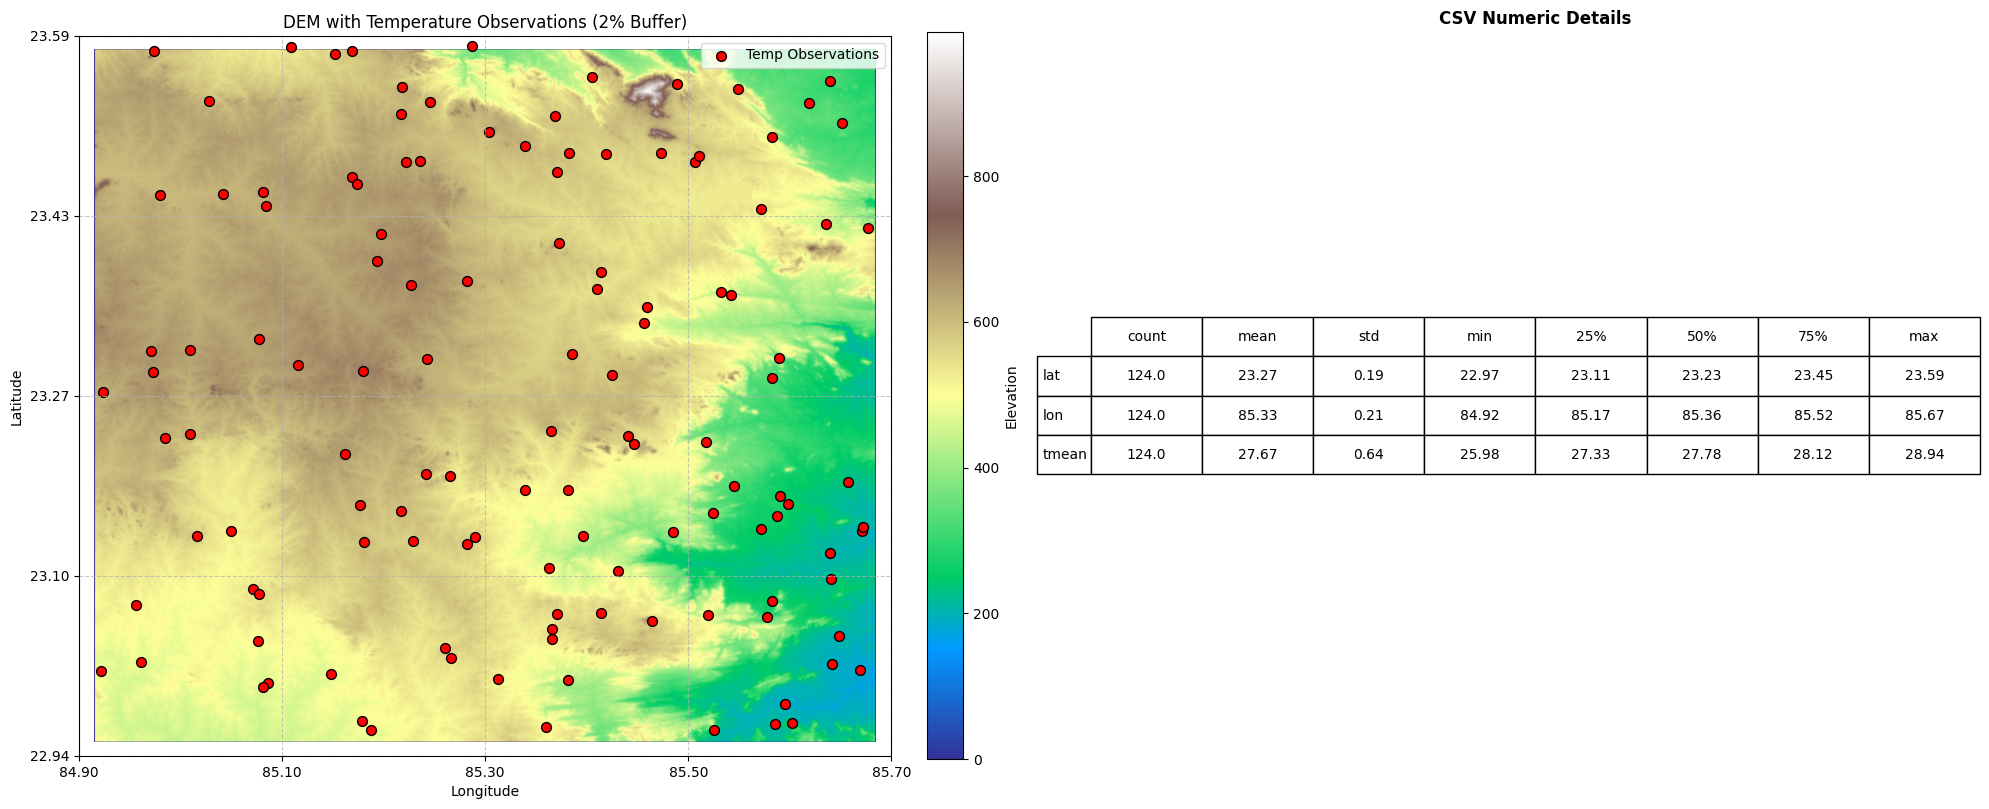

In [ ]:
raster_path = "AP_13298_FBD_F0450_RT1.dem.tif"
with rasterio.open(raster_path) as src:
    dem_data = src.read(1)
    bounds = src.bounds
    crs = src.crs

orig_left, orig_right = bounds.left, bounds.right
orig_bottom, orig_top = bounds.bottom, bounds.top

x_buffer = (orig_right - orig_left) * 0.02
y_buffer = (orig_top - orig_bottom) * 0.02

x_min = orig_left - x_buffer
x_max = orig_right + x_buffer
y_min = orig_bottom - y_buffer
y_max = orig_top + y_buffer

csv_path = "randomized_tmean.csv"
df = pd.read_csv(csv_path)

transformer_to_dem = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
xs, ys = transformer_to_dem.transform(df['lon'].values, df['lat'].values)
df['x'] = xs
df['y'] = ys

stats = df[['lat', 'lon', 'tmean']].describe().T.round(2)

fig, (ax_map, ax_table) = plt.subplots(1, 2, figsize=(20, 8))

im = ax_map.imshow(dem_data, cmap=plt.cm.terrain,
                     extent=[orig_left, orig_right, orig_bottom, orig_top])
ax_map.set_title("DEM with Temperature Observations (2% Buffer)")
ax_map.set_xlabel("Longitude")
ax_map.set_ylabel("Latitude")

ax_map.set_xlim(x_min, x_max)
ax_map.set_ylim(y_min, y_max)

cbar = plt.colorbar(im, ax=ax_map, fraction=0.046, pad=0.04)
cbar.set_label("Elevation")

proj_xticks = np.linspace(x_min, x_max, num=5)
proj_yticks = np.linspace(y_min, y_max, num=5)

proj_to_latlon = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
x_ticks_lon, _ = proj_to_latlon.transform(proj_xticks, np.full_like(proj_xticks, y_min))
_, y_ticks_lat = proj_to_latlon.transform(np.full_like(proj_yticks, x_min), proj_yticks)
ax_map.set_xticks(proj_xticks)
ax_map.set_yticks(proj_yticks)
ax_map.set_xticklabels([f"{lon:.2f}" for lon in x_ticks_lon])
ax_map.set_yticklabels([f"{lat:.2f}" for lat in y_ticks_lat])
ax_map.grid(True, linestyle="--", alpha=0.7)

ax_map.scatter(df['x'], df['y'], c='red', edgecolor='black', marker='o', s=50, label="Temp Observations")
ax_map.legend()

ax_table.axis("off")
table = ax_table.table(cellText=stats.values,
                       rowLabels=stats.index,
                       colLabels=list(stats.columns),
                       loc='center',
                       cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax_table.set_title("Temperature Details", fontweight="bold")

plt.tight_layout()
plt.show()

### 9. Performing the IDW interpolation on temperature observations

Interpolated raster saved to 'IDW_Temperature.tif'


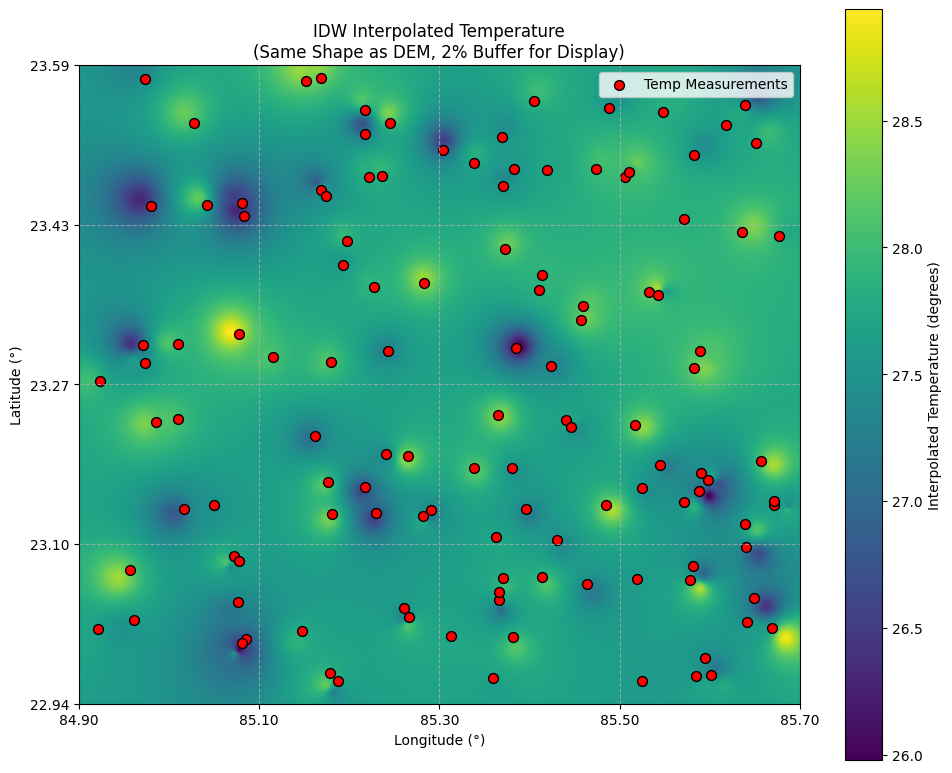

In [27]:
raster_path = "AP_13298_FBD_F0450_RT1.dem.tif"
with rasterio.open(raster_path) as src:
    dem_bounds = src.bounds
    dem_crs = src.crs
    dem_shape = src.shape  # (height, width)
    height, width = src.height, src.width

orig_left   = dem_bounds.left
orig_right  = dem_bounds.right
orig_bottom = dem_bounds.bottom
orig_top    = dem_bounds.top

x_buffer = (orig_right - orig_left) * 0.02
y_buffer = (orig_top - orig_bottom) * 0.02
buffered_left   = orig_left - x_buffer
buffered_right  = orig_right + x_buffer
buffered_bottom = orig_bottom - y_buffer
buffered_top    = orig_top + y_buffer

csv_path = "randomized_tmean.csv"
df = pd.read_csv(csv_path)
transformer_to_dem = Transformer.from_crs("EPSG:4326", dem_crs, always_xy=True)
df['x'], df['y'] = transformer_to_dem.transform(df['lon'].values, df['lat'].values)

inside_mask = (
    (df['x'] >= orig_left) & (df['x'] <= orig_right) &
    (df['y'] >= orig_bottom) & (df['y'] <= orig_top)
)
df_inside = df[inside_mask]
if df_inside.empty:
    raise ValueError("No CSV points fall within the DEM extent!")

cell_size = 12.5  
grid_x = np.arange(orig_left, orig_right + cell_size, cell_size)
grid_y = np.arange(orig_bottom, orig_top + cell_size, cell_size)
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

def idw_interpolation(x_points, y_points, values, xi, yi, power=2):
    interp = np.zeros(xi.shape, dtype=float)
    for i in range(xi.shape[0]):
        for j in range(xi.shape[1]):
            pt_x = xi[i, j]
            pt_y = yi[i, j]
            distances = np.sqrt((x_points - pt_x)**2 + (y_points - pt_y)**2)
            if np.any(distances == 0):
                interp[i, j] = values[distances == 0][0]
            else:
                weights = 1.0 / (distances ** power)
                interp[i, j] = np.sum(weights * values) / np.sum(weights)
    return interp

x_points = df_inside['x'].values
y_points = df_inside['y'].values
rain_values = df_inside['tmean'].values

rain_interp = idw_interpolation(x_points, y_points, rain_values, grid_xx, grid_yy, power=2)

rain_interp_flipped = np.flipud(rain_interp)

out_transform = from_bounds(orig_left, orig_bottom, orig_right, orig_top, width, height)
output_file = "IDW_Temperature.tif"

if os.path.exists(output_file):
    os.remove(output_file)
with rasterio.open(
    output_file, 
    'w', 
    driver='GTiff', 
    height=height, 
    width=width, 
    count=1, 
    dtype=rain_interp.dtype, 
    crs=dem_crs, 
    transform=out_transform
) as dst:
    dst.write(rain_interp_flipped, 1)
print(f"Interpolated raster saved to '{output_file}'")

fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(rain_interp, cmap='viridis', 
               extent=(buffered_left, buffered_right, buffered_bottom, buffered_top), 
               origin='lower')
plt.colorbar(im, ax=ax, label="Interpolated Temperature (degrees)")

ax.scatter(x_points, y_points, c='red', s=50, label="Temp Measurements")
ax.legend()

ax.set_xlim(buffered_left, buffered_right)
ax.set_ylim(buffered_bottom, buffered_top)

dem_to_latlon = Transformer.from_crs(dem_crs, "EPSG:4326", always_xy=True)
xticks = np.linspace(buffered_left, buffered_right, 5)
yticks = np.linspace(buffered_bottom, buffered_top, 5)
lon_ticks, _ = dem_to_latlon.transform(xticks, np.full_like(xticks, buffered_bottom))
_, lat_ticks = dem_to_latlon.transform(np.full_like(yticks, buffered_left), yticks)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xticklabels([f"{lon:.2f}" for lon in lon_ticks])
ax.set_yticklabels([f"{lat:.2f}" for lat in lat_ticks])

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_title("IDW Interpolated Temperature\n(Same Shape as DEM, 2% Buffer for Display)")
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [28]:
rasterio.open('IDW_Temperature.tif').shape

(5564, 6281)

## Preprocessing Land use land cover (LULC)

### 10. Plotting LULC and LULC class statistics

Clipped LULC raster saved to 'clipped_LULC.tif'
Cell size (m): 12.50 x 12.50


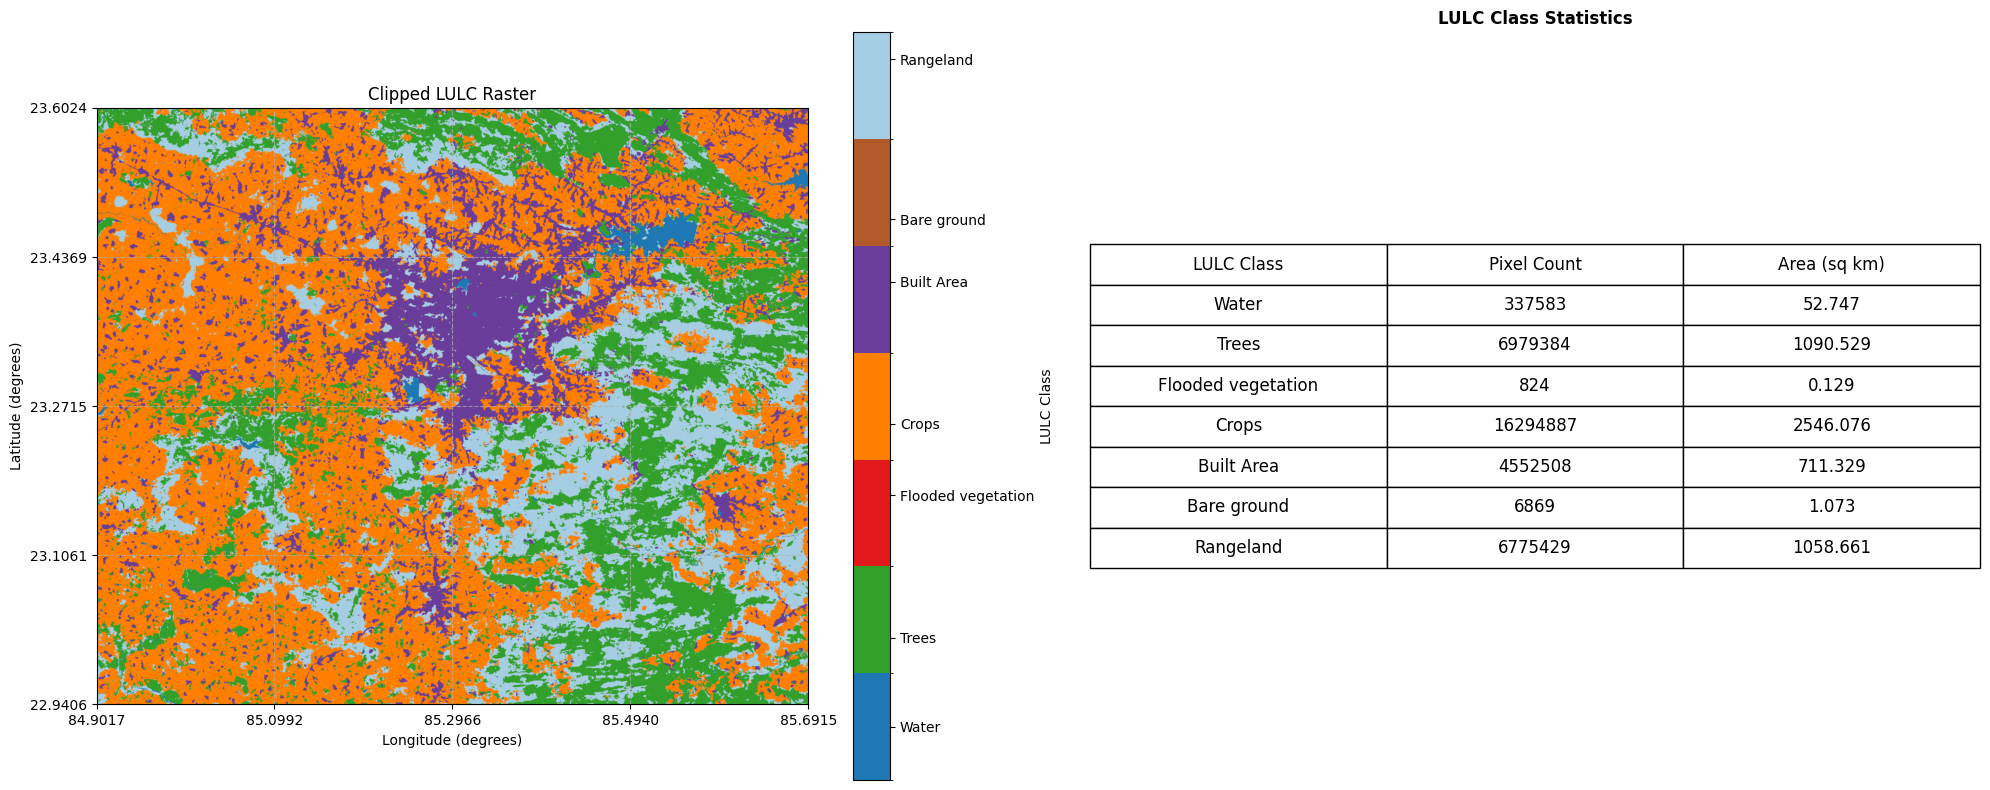

In [ ]:
dem_path = "AP_13298_FBD_F0450_RT1.dem.tif"
with rasterio.open(dem_path) as dem_src:
    dem_bounds = dem_src.bounds  
    dem_crs = dem_src.crs
    dem_shape = dem_src.shape  
    dem_transform = dem_src.transform

lulc_path = "LULC.tif"
with rasterio.open(lulc_path) as lulc_src:
    profile = lulc_src.profile.copy()
    lulc_transform = lulc_src.transform
    lulc_crs = lulc_src.crs
    window = rasterio.windows.from_bounds(dem_bounds.left, dem_bounds.bottom,
                                          dem_bounds.right, dem_bounds.top,
                                          transform=lulc_transform)
    clipped_data = lulc_src.read(1, window=window)
    clipped_transform = rasterio.windows.transform(window, lulc_transform)
    clipped_height, clipped_width = clipped_data.shape

dst_array = np.empty(dem_shape, dtype=clipped_data.dtype)
reproject(
    source=clipped_data,
    destination=dst_array,
    src_transform=clipped_transform,
    src_crs=lulc_crs,
    dst_transform=dem_transform,
    dst_crs=dem_crs,
    resampling=Resampling.nearest
)
clipped_data = dst_array
profile.update({
    "height": dem_shape[0],
    "width": dem_shape[1],
    "transform": dem_transform
})
output_clipped = "clipped_LULC.tif"
if os.path.exists(output_clipped):
    os.remove(output_clipped)
with rasterio.open(output_clipped, "w", **profile) as dst:
    dst.write(clipped_data, 1)
print(f"Clipped LULC raster saved to '{output_clipped}'")

with rasterio.open(output_clipped) as src_for_cell:
    cell_width = src_for_cell.transform.a
    cell_height = abs(src_for_cell.transform.e)
print("Cell size (m): {:.2f} x {:.2f}".format(cell_width, cell_height))

classes, counts = np.unique(clipped_data, return_counts=True)

pixel_width = dem_transform.a
pixel_height = abs(dem_transform.e)
pixel_area_m2 = pixel_width * pixel_height
areas_km2 = counts * pixel_area_m2 / 1e6 

stats_df = pd.DataFrame({
    "Class": classes.astype(int),
    "Pixel Count": counts.astype(int),
    "Area (sq km)": np.round(areas_km2, 3)
})

lulc_excel_path = "LULC_CLassification.xlsx"
lulc_df = pd.read_excel(lulc_excel_path)  

lulc_mapping = dict(zip(lulc_df["Value"], lulc_df["Name"]))

stats_df["LULC Class"] = stats_df["Class"].map(lulc_mapping)
stats_df = stats_df[["LULC Class", "Pixel Count", "Area (sq km)"]]

clipped_left   = dem_transform.c
clipped_top    = dem_transform.f
clipped_right  = clipped_left + dem_transform.a * dem_shape[1]
clipped_bottom = clipped_top + dem_transform.e * dem_shape[0]

x_buffer = (clipped_right - clipped_left) * 0.02
y_buffer = (clipped_top - clipped_bottom) * 0.02
display_left   = clipped_left - x_buffer
display_right  = clipped_right + x_buffer
display_bottom = clipped_bottom - y_buffer
display_top    = clipped_top + y_buffer

crs_to_latlon = Transformer.from_crs(dem_crs, "EPSG:4326", always_xy=True)

lon_min, lat_min = crs_to_latlon.transform(display_left, display_bottom)
lon_max, lat_max = crs_to_latlon.transform(display_right, display_top)
display_extent = (lon_min, lon_max, lat_min, lat_max)

unique_vals = np.array(sorted([val for val in np.unique(clipped_data) if val in lulc_mapping]))

boundaries = [unique_vals[0] - 0.5]
for i in range(len(unique_vals) - 1):
    boundaries.append((unique_vals[i] + unique_vals[i+1]) / 2)
boundaries.append(unique_vals[-1] + 0.5)
boundaries = np.array(boundaries)

num_classes = len(unique_vals)
colors = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#b15928', '#a6cee3', '#fb9a99', '#fdbf6f']
colors = colors[:num_classes]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

fig, (ax_map, ax_table) = plt.subplots(1, 2, figsize=(20, 8))

im = ax_map.imshow(clipped_data, cmap=cmap, norm=norm, extent=display_extent, origin="upper")
ax_map.set_title("Clipped LULC Raster")
ax_map.set_xlabel("Longitude (degrees)")
ax_map.set_ylabel("Latitude (degrees)")

cbar = plt.colorbar(im, ax=ax_map, boundaries=boundaries, ticks=unique_vals, label="LULC Class")
cbar.ax.set_yticklabels([lulc_mapping[val] for val in unique_vals])

xticks = np.linspace(lon_min, lon_max, 5)
yticks = np.linspace(lat_min, lat_max, 5)
ax_map.set_xticks(xticks)
ax_map.set_yticks(yticks)
ax_map.grid(True, linestyle="--", alpha=0.7)

ax_table.axis("off")
table_data = stats_df.values.tolist()
col_labels = stats_df.columns.tolist()
table_obj = ax_table.table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
table_obj.auto_set_font_size(False)
table_obj.set_fontsize(12)
table_obj.scale(1, 2)
ax_table.set_title("LULC Class Statistics", fontweight="bold")

plt.tight_layout()
plt.show()

In [10]:
rasterio.open('clipped_LULC.tif').shape

(5564, 6281)

In [8]:
rasterio.open('AP_13298_FBD_F0450_RT1.dem.tif').shape

(5564, 6281)

## FINAL SUITABILITY ASSESSMENT

### 11. Checking the metadata of rasters for assessment

In [ ]:
raster_files = {
    "elevation": "AP_13298_FBD_F0450_RT1.dem.tif",
    "slope": "AP_13298_slope.tif",
    "rainfall": "IDW_Rainfall.tif",
    "temperature": "IDW_Temperature.tif",
    "lulc": "clipped_LULC.tif"
}

rasters = {}

print("Raster Properties:")
print("-" * 60)
for crit, filename in raster_files.items():
    with rasterio.open(filename) as src:
        shape = src.shape
        res = src.res
        bounds = src.bounds
        crs = src.crs
        data = src.read(1)
        rasters[crit] = {
            "data": data,
            "shape": shape,
            "res": res,
            "bounds": bounds,
            "crs": crs
        }
        print(f"Criterion: {crit}")
        print(f"  Shape      : {shape}")
        print(f"  Resolution : {res}")
        print(f"  Bounds     : {bounds}")
        print(f"  CRS        : {crs}")
        print("-" * 60)

Raster Properties:
------------------------------------------------------------
Criterion: elevation
  Shape      : (5564, 6281)
  Resolution : (12.5, 12.5)
  Bounds     : BoundingBox(left=286409.625, bottom=2539875.75, right=364922.125, top=2609425.75)
  CRS        : EPSG:32645
------------------------------------------------------------
Criterion: slope
  Shape      : (5564, 6281)
  Resolution : (12.5, 12.5)
  Bounds     : BoundingBox(left=286409.625, bottom=2539875.75, right=364922.125, top=2609425.75)
  CRS        : EPSG:32645
------------------------------------------------------------
Criterion: rainfall
  Shape      : (5564, 6281)
  Resolution : (12.5, 12.5)
  Bounds     : BoundingBox(left=286409.625, bottom=2539875.75, right=364922.125, top=2609425.75)
  CRS        : EPSG:32645
------------------------------------------------------------
Criterion: temperature
  Shape      : (5564, 6281)
  Resolution : (12.5, 12.5)
  Bounds     : BoundingBox(left=286409.625, bottom=2539875.75, 

### 12. Computing AHP weights

In [ ]:
criteria = ["elevation", "slope", "rainfall", "temperature", "lulc"]

pairwise = np.array([
    [1,      1/3,    1/5,    1/4,    1/2],
    [3,      1,      1/2,    1/2,    1],
    [5,      2,      1,      3,      4],
    [4,      2,      1/3,    1,      2],
    [2,      1,      1/4,    1/2,    1]
])

eigvals, eigvecs = np.linalg.eig(pairwise)
max_index = np.argmax(eigvals.real)
raw_eigenvector = eigvecs[:, max_index].real

normalized_weights = raw_eigenvector / np.sum(raw_eigenvector)

principal_eigenvalue = eigvals[max_index].real

weights_df = pd.DataFrame({
    "Criterion": criteria,
    "Raw Eigenvector": np.round(raw_eigenvector, 4),
    "AHP Weight": np.round(normalized_weights, 4)
})

print("\nPrincipal Eigenvalue: {:.4f}".format(principal_eigenvalue))
print("\nAHP Weights Table:")
print(weights_df)


Principal Eigenvalue: 5.1303

AHP Weights Table:
     Criterion  Raw Eigenvector  AHP Weight
0    elevation           0.1166      0.0620
1        slope           0.2907      0.1546
2     rainfall           0.8154      0.4335
3  temperature           0.4300      0.2286
4         lulc           0.2283      0.1214


### 13. Performing Weighted Overlay & creating a composite suitability map by summing each criterion multiplied by its weight.

In [ ]:
suitability = (
    weights[0] * rasters["elevation"]["data"] +
    weights[1] * rasters["slope"]["data"] +
    weights[2] * rasters["rainfall"]["data"] +
    weights[3] * rasters["temperature"]["data"] +
    weights[4] * rasters["lulc"]["data"]
)

### 14. Plotting the Composite Suitability Map

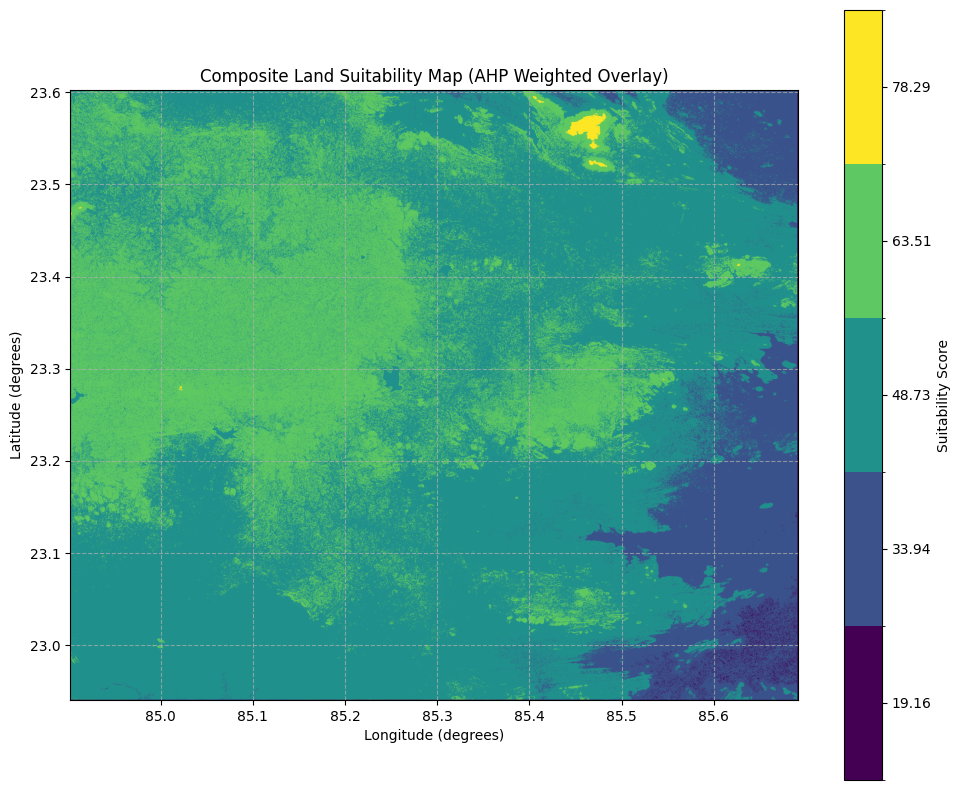

In [ ]:
base_bounds = rasters["elevation"]["bounds"]

from pyproj import Transformer

transformer = Transformer.from_crs(rasters["elevation"]["crs"], "EPSG:4326", always_xy=True)
min_lon_deg, min_lat_deg = transformer.transform(base_bounds.left, base_bounds.bottom)
max_lon_deg, max_lat_deg = transformer.transform(base_bounds.right, base_bounds.top)

x_buffer = (max_lon_deg - min_lon_deg) * 0.02
y_buffer = (max_lat_deg - min_lat_deg) * 0.02
display_extent = (
    min_lon_deg - x_buffer,
    max_lon_deg + x_buffer,
    min_lat_deg - y_buffer,
    max_lat_deg + y_buffer
)

plt.figure(figsize=(10, 8))
num_bins = 5
min_val = np.nanmin(suitability)
max_val = np.nanmax(suitability)
boundaries = np.linspace(min_val, max_val, num_bins+1)
from matplotlib.colors import BoundaryNorm
cmap = plt.get_cmap('viridis', num_bins)
norm = BoundaryNorm(boundaries, cmap.N)

im = plt.imshow(suitability, cmap=cmap, norm=norm, extent=display_extent, origin="upper")
plt.title("Composite Land Suitability Map (AHP Weighted Overlay)")
plt.xlabel("Longitude (degrees)")
plt.ylabel("Latitude (degrees)")
cbar = plt.colorbar(im, ticks=(boundaries[:-1] + boundaries[1:]) / 2, label="Suitability Score")
cbar.ax.set_yticklabels([f"{(boundaries[i] + boundaries[i+1]) / 2:.2f}" for i in range(num_bins)])
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()